In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [162]:
# loading in London weather dataset
df = pd.read_csv("/Users/cartermain/Downloads/london_weather.csv")

In [163]:
# counting null values
print(df.isnull().sum())
print("\n")

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64




Going to need to replace null values for snow depth with 0. Let's start with days that had 0 recorded precipitation.

In [164]:
# counting rows that meet this criteria
print(sum((df["snow_depth"].isnull()) & (df["precipitation"] == 0)))

758


In [165]:
# replacing all null snow_depth days that had 0 precipitation with 0 for snow_depth
df.loc[(df["snow_depth"].isnull()) & (df["precipitation"] == 0), "snow_depth"] = 0

Now, we can replace all days with a min temp above the temperature needed for snow to accumulate on the ground (5° C according to the National Snow & Ice Data Center: https://nsidc.org/learn/parts-cryosphere/snow/science-snow)

In [166]:
# identifying number of rows that meet this criteria
print(sum((df["snow_depth"].isnull()) & (df["min_temp"] > 5)))

625


In [167]:
# replacing null values with 0 for snow_depth
df.loc[(df["snow_depth"].isnull()) & (df["min_temp"] > 5), "snow_depth"] = 0

In [168]:
# taking a look at fresh null count after changes
print(df.isnull().sum())
print(len(df))

date                 0
cloud_cover         19
sunshine             0
global_radiation    19
max_temp             6
mean_temp           36
min_temp             2
precipitation        6
pressure             4
snow_depth          58
dtype: int64
15341


We've now gotten null value count down to less than 1% of the original dataset size so I am comfortable dropping remaining rows with null values

In [169]:
# dropping rows with null values
df.dropna(inplace = True)

Now, let's check for some outliers before getting into our model

In [170]:
# checking max and min values relative to mean, 25%, and 75%
print(df.describe())

               date   cloud_cover      sunshine  global_radiation  \
count  1.520700e+04  15207.000000  15207.000000      15207.000000   
mean   1.999494e+07      5.269678      4.349464        119.022555   
std    1.209193e+05      2.067057      4.022147         88.942076   
min    1.979010e+07      0.000000      0.000000          8.000000   
25%    1.989061e+07      4.000000      0.500000         41.000000   
50%    1.999112e+07      6.000000      3.500000         95.000000   
75%    2.010061e+07      7.000000      7.200000        186.000000   
max    2.020123e+07      9.000000     16.000000        402.000000   

           max_temp     mean_temp      min_temp  precipitation       pressure  \
count  15207.000000  15207.000000  15207.000000   15207.000000   15207.000000   
mean      15.402223     11.493293      7.576511       1.666739  101536.427303   
std        6.549930      5.723116      5.323478       3.736406    1048.041358   
min       -6.200000     -7.600000    -11.800000       

In [171]:
# creating a list of columns to check for outliers in (ignoring snow depth becaude 25% and 75% are 0)
columns_to_inspect = ["cloud_cover", "sunshine", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "pressure"]

In [172]:
# using interquartile range to turn outliers into null values
for feature in columns_to_inspect:
    # looking at top and bottom 100 values for each feature to expedite the loop and save space
    for x in df[feature].sort_values(ascending = False)[0:100]:
        q75 = df[feature].describe()["75%"]
        q25 = df[feature].describe()["25%"]
        intr_qr = q75 - q25
        max = q75 + (1.5 * intr_qr)
        min = q25 - (1.5 * intr_qr)
        if x > max or x < min:
            df.loc[df[feature] == x, feature] = np.nan
    for x in df[feature][df[feature].notnull() == True].sort_values(ascending = False)[-100:]:
        if x > max or x < min:
            df.loc[df[feature] == x, feature] = np.nan

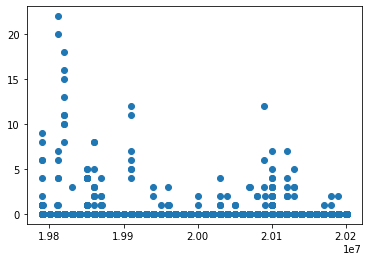

<Figure size 432x288 with 0 Axes>

In [173]:
# checking for outlier values on snow depth outside of loop due to 25% and 75% being 0
plt.scatter(df["date"], df["snow_depth"])
plt.show()
plt.clf()

In [174]:
# based on the visualization, let's drop anything over 14
df.loc[df["snow_depth"] > 14, "snow_depth"] = np.nan

In [175]:
# checking null count after loop
print(df.isnull().sum())

date                  0
cloud_cover           0
sunshine              0
global_radiation      0
max_temp             11
mean_temp             1
min_temp              7
precipitation       102
pressure            121
snow_depth            5
dtype: int64


In [176]:
# dropping na values
df.dropna(inplace = True)

In [177]:
# checking how these drops changed each feature
print(df.describe())

               date   cloud_cover      sunshine  global_radiation  \
count  1.496500e+04  14965.000000  14965.000000      14965.000000   
mean   1.999506e+07      5.258069      4.381196        119.744604   
std    1.207051e+05      2.067708      4.027522         89.029063   
min    1.979010e+07      0.000000      0.000000         10.000000   
25%    1.989063e+07      4.000000      0.500000         42.000000   
50%    1.999113e+07      6.000000      3.600000         97.000000   
75%    2.010060e+07      7.000000      7.200000        187.000000   
max    2.020123e+07      9.000000     16.000000        402.000000   

           max_temp     mean_temp      min_temp  precipitation       pressure  \
count  14965.000000  14965.000000  14965.000000   14965.000000   14965.000000   
mean      15.445493     11.519419      7.590765       1.476866  101562.484464   
std        6.525175      5.702269      5.303710       2.987897    1006.659489   
min       -4.000000     -5.400000     -8.500000       

Now that we have gotten rid of outliers, we can run our linear regression with scaled data to predict pressure

In [178]:
# collecting features
features = df[["date", "pressure", "cloud_cover", "global_radiation", "max_temp", "mean_temp", "min_temp", "precipitation", "snow_depth"]]

In [179]:
# scaling feature set
scaler = StandardScaler()
scaler.fit_transform(features)

array([[-1.6980744 ,  0.33529393, -1.57574353, ..., -2.84541744,
        -0.36042135, 23.41201292],
       [-1.69806612,  0.96114712,  0.35883012, ..., -2.84541744,
        -0.49429923, 20.80298774],
       [-1.69805783,  0.48430659, -0.12481329, ..., -2.78885137,
        -0.49429923, 10.36688702],
       ...,
       [ 1.70809154, -2.71449859,  0.84247354, ..., -1.22385685,
        -0.49429923, -0.0692137 ],
       [ 1.70809982, -1.35351626,  0.35883012, ..., -1.45012112,
        -0.49429923, -0.0692137 ],
       [ 1.70810811, -1.05549093,  0.84247354, ..., -2.01578179,
        -0.49429923, -0.0692137 ]])

In [180]:
# train test splitting with random state of 42
x_train, x_test, y_train, y_test = train_test_split(features, df["sunshine"], train_size = 0.7, random_state = 42)

In [181]:
# training and scoring model
model = LinearRegression()
model.fit(x_train, y_train)
print(model.score(x_test, y_test))

0.8836567894920055


Time to run RFE to see which features we can drop

In [182]:
# running via a for loop to test every possible number of features and only keep if it resulted in a 10%+ increase to save computational space
max_score = 0.01
best_x = 0
for x in range(1,len(features.columns) + 1):
    rfe = RFE(estimator = model, n_features_to_select = x)
    rfe.fit(x_train, y_train)
    score = rfe.score(x_test, y_test)
    if (score - max_score) / max_score > .10:
        max_score = score
        best_x = x
print(max_score, best_x)

0.8827334896130821 7


In [183]:
# finding out which features RFE decided to keep and drop
rfe = RFE(estimator = model, n_features_to_select = best_x)
rfe.fit(x_train, y_train)
rfe.score(x_test, y_test)
print(rfe.support_)

[False False  True  True  True  True  True  True  True]


In [184]:
# collecting column names of features kept by RFE
kept_features = []
y = 0
for kept in rfe.support_:
    if kept == True:
        kept_features.append(features.columns[y])
    y += 1

In [185]:
# creating revised feature set
features_2 = df[kept_features]

In [186]:
# scaling new features set 
scaler_2 = StandardScaler()
scaler_2.fit_transform(features_2)

array([[-1.57574353, -0.76095227, -2.01464819, ..., -2.84541744,
        -0.36042135, 23.41201292],
       [ 0.35883012, -1.04176883, -2.12192859, ..., -2.84541744,
        -0.49429923, 20.80298774],
       [-0.12481329, -1.1990261 , -2.16790591, ..., -2.78885137,
        -0.49429923, 10.36688702],
       ...,
       [ 0.84247354, -1.1091648 , -1.73878431, ..., -1.22385685,
        -0.49429923, -0.0692137 ],
       [ 0.35883012, -1.09793214, -1.50889773, ..., -1.45012112,
        -0.49429923, -0.0692137 ],
       [ 0.84247354, -0.96314019, -2.13725437, ..., -2.01578179,
        -0.49429923, -0.0692137 ]])

In [187]:
# resplitting with new feature set keeping random state as 42
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(features_2, df["sunshine"], train_size = 0.7, random_state = 42)

In [188]:
# retraining model with revised feature set
model.fit(x_train_2, y_train_2)
print(model.score(x_test_2, y_test_2))

0.8827334896130821


In [189]:
# running a for loop to test train sizes in 0.05 increments and find the top performing train size
best_split = 0
best_score = 0
for x in np.linspace(0, 1, 21):
    if x == 0 or x == 1:
        continue
    else: 
        x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(features_2, df["sunshine"], train_size = x, random_state = 42)
        model.fit(x_train_3, y_train_3)
        score = model.score(x_test_3, y_test_3)
        if score > best_score:
            best_score = score
            best_split = x

In [190]:
# finding best performers
print(best_score, best_split)

0.8845327258653198 0.75


In [191]:
# resplitting revised feature set at best train size
best_x_train, best_x_test, best_y_train, best_y_test = train_test_split(features_2, df["sunshine"], train_size = best_split, random_state = 42)

In [192]:
# retraining our model one final time with this new split
model.fit(best_x_train, best_y_train)
print(model.score(best_x_test, best_y_test))

0.8845327258653198


Lastly, let's check the coefficients of each feature for our model

In [193]:
# running a for loop to print feature name and rounded coefficient
x = 0
for feature in features_2.columns:
    print(feature + ": " + str(round(model.coef_[x],2)))
    x += 1

cloud_cover: -0.74
global_radiation: 0.03
max_temp: -0.09
mean_temp: 0.14
min_temp: -0.14
precipitation: -0.04
snow_depth: -0.07
